## Generate map art using Neural Style Transfer 

In [29]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [30]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [31]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

## Input image - Eye of Sahara

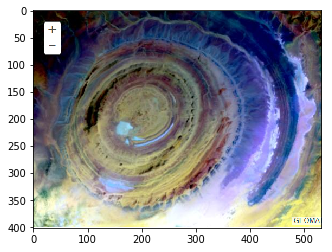

In [32]:
img_fn = 'data/stylexfer/EyeOfSahara2.png'
img = open_image(img_fn)
plt.imshow(img);

### Image processing

In [33]:
sz=288

In [34]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

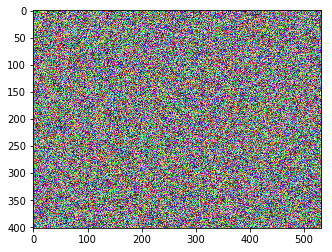

In [35]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [36]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

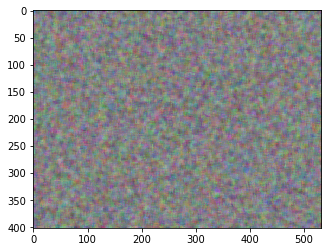

In [37]:
plt.imshow(opt_img);

In [38]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [39]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [40]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [41]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [42]:
def actn_loss(x): 
    return F.mse_loss(m_vgg(x), targ_v)*1000

In [43]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: 
        print(f'Iteration: n_iter, loss: {loss.data[0]}')
    return loss

In [156]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step, actn_loss))

Iteration: n_iter, loss: 0.5608938336372375
Iteration: n_iter, loss: 0.2663968801498413
Iteration: n_iter, loss: 0.18422582745552063
Iteration: n_iter, loss: 0.14729347825050354
Iteration: n_iter, loss: 0.12594646215438843
Iteration: n_iter, loss: 0.11200997233390808
Iteration: n_iter, loss: 0.10181093215942383
Iteration: n_iter, loss: 0.09400349855422974
Iteration: n_iter, loss: 0.08833562582731247
Iteration: n_iter, loss: 0.08383708447217941


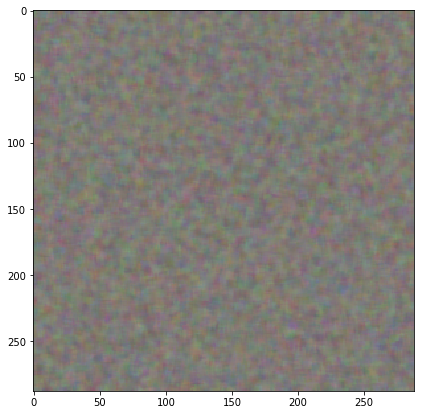

In [44]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [45]:
class SaveFeatures():
    
    features=None
    
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): 
        self.features = output
        
    def close(self): 
        self.hook.remove()

In [159]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [46]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32]

In [47]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [48]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [49]:
opt_img_v, optimizer = get_opt()

In [50]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [51]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [166]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 0.23958823084831238
Iteration: n_iter, loss: 0.09852331131696701
Iteration: n_iter, loss: 0.06309153884649277
Iteration: n_iter, loss: 0.047044530510902405
Iteration: n_iter, loss: 0.03738176077604294
Iteration: n_iter, loss: 0.03139948099851608
Iteration: n_iter, loss: 0.027291318401694298
Iteration: n_iter, loss: 0.024268880486488342
Iteration: n_iter, loss: 0.02195042185485363
Iteration: n_iter, loss: 0.02008049003779888


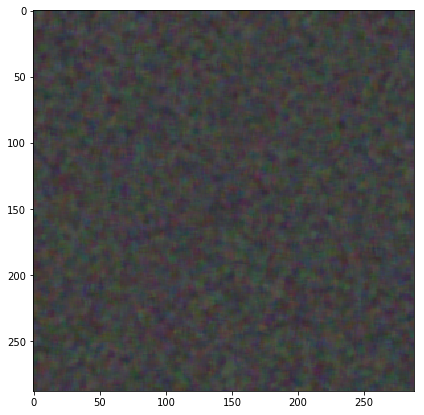

In [52]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [168]:
sf.close()

In [53]:
style_fn = 'data/stylexfer/horse.png' #starry-night.jpg'

style_img = open_image(style_fn)
style_img.shape, img.shape

((809, 812, 3), (402, 533, 3))

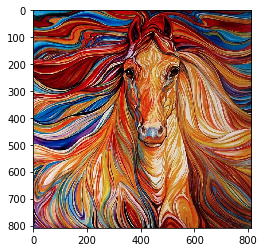

In [54]:
plt.imshow(style_img);

In [55]:
def scale_match(src, targ):
    h,w,_ = img.shape
    sh,sw,_ = style_img.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(style_img, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [56]:
style = scale_match(img, style_img)

## Style image

((402, 533, 3), (402, 533, 3))

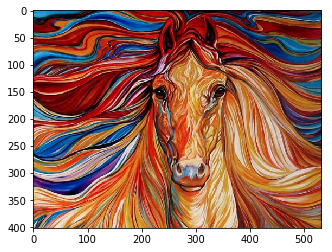

In [57]:
plt.imshow(style)
style.shape, img.shape

### Style Transfer Network

In [58]:
opt_img_v, optimizer = get_opt()

In [59]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [60]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36])]

In [61]:
style_tfm = val_tfms(style_img)

In [62]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36])]

In [63]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [64]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [65]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 491.8005065917969
Iteration: n_iter, loss: 49.342079162597656
Iteration: n_iter, loss: 10.45976448059082
Iteration: n_iter, loss: 4.658120155334473
Iteration: n_iter, loss: 2.9193801879882812
Iteration: n_iter, loss: 2.1225545406341553
Iteration: n_iter, loss: 1.675369143486023
Iteration: n_iter, loss: 1.3923845291137695
Iteration: n_iter, loss: 1.2080638408660889
Iteration: n_iter, loss: 1.074087142944336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


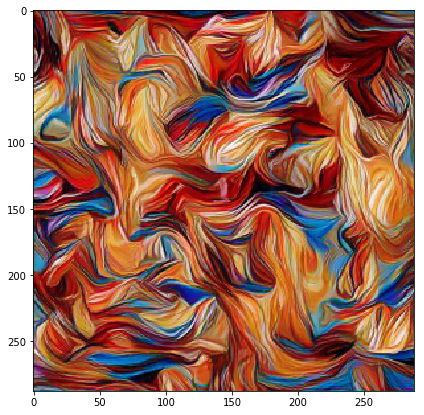

In [66]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [118]:
for sf in sfs: sf.close()

In [67]:
opt_img_v, optimizer = get_opt()

In [68]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [69]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [70]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 2741.78564453125
Iteration: n_iter, loss: 1665.0955810546875
Iteration: n_iter, loss: 1351.0888671875
Iteration: n_iter, loss: 1186.2196044921875
Iteration: n_iter, loss: 1091.9854736328125
Iteration: n_iter, loss: 1032.227783203125
Iteration: n_iter, loss: 985.1212768554688
Iteration: n_iter, loss: 946.6204833984375
Iteration: n_iter, loss: 919.203125
Iteration: n_iter, loss: 898.1991577148438


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


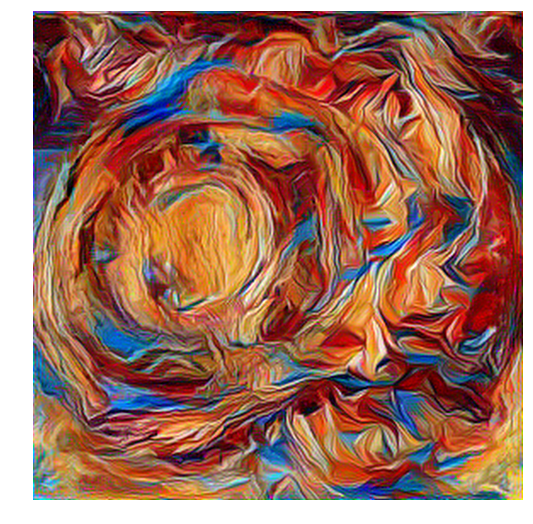

In [71]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [189]:
for sf in sfs: sf.close()

In [72]:
opt_img_v, optimizer = get_opt()

In [73]:
def comb_loss_content(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + 0.1*style_loss

In [74]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [75]:
n_iter=0
while n_iter <= max_iter: 
    optimizer.step(partial(step, comb_loss_content))

Iteration: n_iter, loss: 1012.2846069335938
Iteration: n_iter, loss: 571.38818359375
Iteration: n_iter, loss: 424.9115295410156
Iteration: n_iter, loss: 349.1339111328125
Iteration: n_iter, loss: 302.654052734375
Iteration: n_iter, loss: 272.3329772949219
Iteration: n_iter, loss: 251.40274047851562
Iteration: n_iter, loss: 237.22573852539062
Iteration: n_iter, loss: 227.13821411132812
Iteration: n_iter, loss: 219.46221923828125


In [90]:
for sf in sfs: sf.close()

## Stylized image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


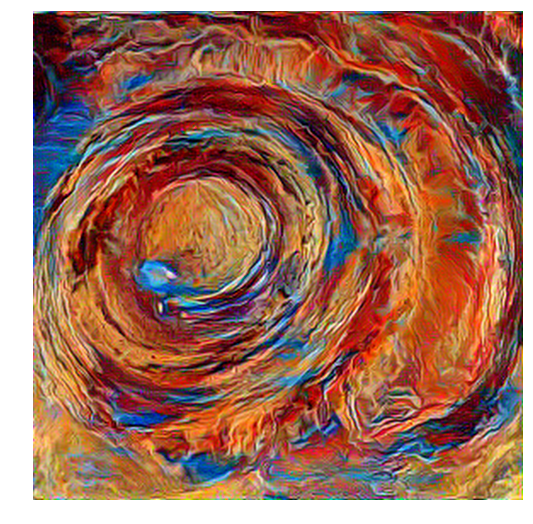

In [76]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');